# Global Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Define Paths

In [3]:
notebook_dir: str = os.path.abspath(".")
data_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir,
    "data",
    "lambda"
)

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

file_paths: list[str] = glob.glob(images_path_glob)


# Extract Labels

In [4]:

labeled_image_paths: list[tuple[str, str]] = []

file_path: str
for file_path in file_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
file_paths: list[str]
labels, file_paths =  list(zip(*labeled_image_paths))


# Load Dataset

In [5]:
dataset_split: float = 0.8
split_index: int = int(len(file_paths)*dataset_split)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=file_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.3,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=file_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




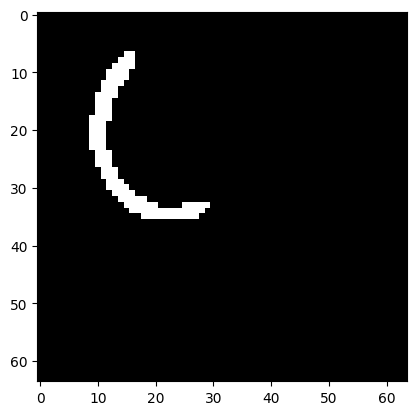

tensor([1., 0., 0., 0., 0., 0., 0.])


In [6]:
for im, lab in train_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

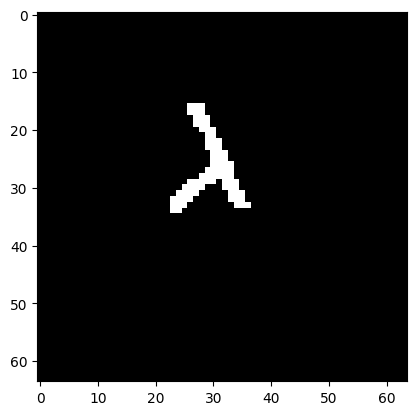

tensor([0., 0., 0., 0., 0., 1., 0.])


In [7]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [8]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=False,
    batch_size=16
)

# Define Model Hyperparameters

In [9]:

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 16, 16, 16),
        "fully_connected_features": (7,),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "verbose": True
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0001,
        "weight_decay": 0.0001
    }
]


# Train

In [10]:

for epoch in range(100):

    log: EpochLogs
    for log in grid_search(
        model_factor=AllCNN2D,
        all_model_parameters=all_model_parameters,
        optim_factory=AdamW,
        all_optim_params=all_optim_parameters,
        epochs=100,
        criterion=nn.CrossEntropyLoss(),
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        lr_decay_window_size=10,
        lr_decay_minimum=0.0,
        scheduler_scale=0.5,
        device="cuda"
    ):
        train_logpoints: list[LogPoint] = log.train_logs
        val_logpoints: list[LogPoint] = log.val_logs
        

        train_count: int = 0
        val_count: int = 0
        
        train_losses_tally: float = 0.0
        val_losses_tally: float = 0.0
        
        train_correct_tally: int = 0
        val_correct_tally: int = 0
        
        for log_point in train_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            train_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            train_losses_tally += torch.sum(log_point.loss)
            
            train_count += len(y_hat_pred)
            
        for log_point in val_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            val_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            val_losses_tally += torch.sum(log_point.loss)
            
            val_count += len(y_hat_pred)
            
        train_accuracy: float = train_correct_tally/train_count
        val_accuracy: float = val_correct_tally/val_count
        
        train_loss: float = train_losses_tally/train_count
        val_loss: float = val_losses_tally/val_count
        
        print(f"Train Accuracy: {train_accuracy}")
        print(f"Val Accuracy: {val_accuracy}")
        print(f"Loss: {train_loss}")
        print(f"Val Loss: {val_loss}")
        

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 7]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 16, 32, 32]           2,320
│    │  

Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.09917355328798294
Val Accuracy: 0.1818181872367859
Loss: 0.13348644971847534
Val Loss: 0.12893137335777283


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.14049586653709412
Val Accuracy: 0.1818181872367859
Loss: 0.13037444651126862
Val Loss: 0.12897953391075134


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.22314049303531647
Val Accuracy: 0.1735537201166153
Loss: 0.12634962797164917
Val Loss: 0.1286250203847885


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.22314049303531647
Loss: 0.12723402678966522
Val Loss: 0.128427654504776


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.23140496015548706
Val Accuracy: 0.20661157369613647
Loss: 0.1262984573841095
Val Loss: 0.12746687233448029


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.19834710657596588
Val Accuracy: 0.28925618529319763
Loss: 0.1235482394695282
Val Loss: 0.12514294683933258


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.21487602591514587
Val Accuracy: 0.3057851195335388
Loss: 0.12476328015327454
Val Loss: 0.1244160532951355


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.25619834661483765
Val Accuracy: 0.2975206673145294
Loss: 0.12130468338727951
Val Loss: 0.12081985175609589


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.28925618529319763
Val Accuracy: 0.3140496015548706
Loss: 0.12067589908838272
Val Loss: 0.1205311194062233


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.24793387949466705
Val Accuracy: 0.3057851195335388
Loss: 0.12096995860338211
Val Loss: 0.119171142578125


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.3636363744735718
Val Accuracy: 0.3305785059928894
Loss: 0.11601557582616806
Val Loss: 0.1201048418879509


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3388429880142212
Val Accuracy: 0.3471074402332306
Loss: 0.11805494874715805
Val Loss: 0.11829938739538193


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.3636363744735718
Val Accuracy: 0.3057851195335388
Loss: 0.11348506808280945
Val Loss: 0.11845515668392181


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.2975206673145294
Val Accuracy: 0.28925618529319763
Loss: 0.11605305224657059
Val Loss: 0.11983193457126617


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3636363744735718
Val Accuracy: 0.41322314739227295
Loss: 0.11506263166666031
Val Loss: 0.11726026237010956


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.3305785059928894
Val Accuracy: 0.35537189245224
Loss: 0.1141461431980133
Val Loss: 0.11553244292736053


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3388429880142212
Val Accuracy: 0.3801652789115906
Loss: 0.11449450999498367
Val Loss: 0.11445149779319763


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.35537189245224
Val Accuracy: 0.3801652789115906
Loss: 0.11029913276433945
Val Loss: 0.1145506277680397


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.41322314739227295
Val Accuracy: 0.3719008266925812
Loss: 0.11087886989116669
Val Loss: 0.112876757979393


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.2975206673145294
Val Accuracy: 0.39669421315193176
Loss: 0.11110324412584305
Val Loss: 0.11047054082155228


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3719008266925812
Val Accuracy: 0.41322314739227295
Loss: 0.11095499992370605
Val Loss: 0.1107432171702385


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.3719008266925812
Loss: 0.1118624359369278
Val Loss: 0.11124255508184433


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: 0.35537189245224
Val Accuracy: 0.40495866537094116
Loss: 0.11004350334405899
Val Loss: 0.10948190838098526


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.38842976093292236
Loss: 0.11001482605934143
Val Loss: 0.10906940698623657


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3471074402332306
Val Accuracy: 0.38842976093292236
Loss: 0.10927747935056686
Val Loss: 0.10871065407991409


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.39669421315193176
Val Accuracy: 0.41322314739227295
Loss: 0.10905171185731888
Val Loss: 0.10779696702957153


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.3471074402332306
Val Accuracy: 0.3719008266925812
Loss: 0.10817477107048035
Val Loss: 0.111615389585495


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.42975205183029175
Loss: 0.10359364002943039
Val Loss: 0.10887676477432251


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.3471074402332306
Loss: 0.10508443415164948
Val Loss: 0.10845868289470673


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.3719008266925812
Val Accuracy: 0.38842976093292236
Loss: 0.10680075734853745
Val Loss: 0.1083315908908844


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.40495866537094116
Loss: 0.1034739688038826
Val Loss: 0.10477408766746521


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.3471074402332306
Loss: 0.10627764463424683
Val Loss: 0.10870946198701859


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.40495866537094116
Val Accuracy: 0.42148759961128235
Loss: 0.1038954108953476
Val Loss: 0.10299991071224213


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.40495866537094116
Val Accuracy: 0.42148759961128235
Loss: 0.10228696465492249
Val Loss: 0.10419245064258575


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.39669421315193176
Val Accuracy: 0.41322314739227295
Loss: 0.1018095463514328
Val Loss: 0.10494092851877213


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.35537189245224
Loss: 0.10172311216592789
Val Loss: 0.10410673171281815


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4876033067703247
Val Accuracy: 0.3801652789115906
Loss: 0.10041315853595734
Val Loss: 0.10223440825939178


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.3719008266925812
Loss: 0.09999678283929825
Val Loss: 0.10512019693851471


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4545454680919647
Val Accuracy: 0.4545454680919647
Loss: 0.10055874288082123
Val Loss: 0.10181096196174622


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.40495866537094116
Loss: 0.09996744245290756
Val Loss: 0.10160519927740097


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3719008266925812
Val Accuracy: 0.40495866537094116
Loss: 0.10085926949977875
Val Loss: 0.1018449142575264


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.4628099203109741
Loss: 0.10064013302326202
Val Loss: 0.09873213618993759


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.3801652789115906
Val Accuracy: 0.35537189245224
Loss: 0.1005396917462349
Val Loss: 0.10234223306179047


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.3636363744735718
Val Accuracy: 0.4628099203109741
Loss: 0.10100226104259491
Val Loss: 0.10018397867679596


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.40495866537094116
Val Accuracy: 0.39669421315193176
Loss: 0.09833278506994247
Val Loss: 0.10152377188205719


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.39669421315193176
Loss: 0.09964719414710999
Val Loss: 0.10068279504776001


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3719008266925812
Val Accuracy: 0.43801653385162354
Loss: 0.09847643971443176
Val Loss: 0.09975374490022659


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.39669421315193176
Val Accuracy: 0.41322314739227295
Loss: 0.09676813334226608
Val Loss: 0.09519104659557343


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.42148759961128235
Loss: 0.09750285744667053
Val Loss: 0.10009203851222992


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.40495866537094116
Val Accuracy: 0.3471074402332306
Loss: 0.09525065124034882
Val Loss: 0.09871689230203629


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.4628099203109741
Loss: 0.09789067506790161
Val Loss: 0.09622661769390106


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.5206611752510071
Val Accuracy: 0.42148759961128235
Loss: 0.09495145082473755
Val Loss: 0.09630607068538666


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.38842976093292236
Val Accuracy: 0.4628099203109741
Loss: 0.09453932195901871
Val Loss: 0.09476615488529205


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.4793388545513153
Loss: 0.09291788190603256
Val Loss: 0.09298630058765411


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.42148759961128235
Loss: 0.09463969618082047
Val Loss: 0.09668368101119995


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.3801652789115906
Val Accuracy: 0.4876033067703247
Loss: 0.09619507938623428
Val Loss: 0.09611957520246506


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.4876033067703247
Loss: 0.09409558027982712
Val Loss: 0.09537504613399506


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.44628098607063293
Loss: 0.09240536391735077
Val Loss: 0.09516873210668564


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.4545454680919647
Loss: 0.09235233813524246
Val Loss: 0.09285230189561844


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.5454545617103577
Loss: 0.0930357575416565
Val Loss: 0.08978382498025894


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.5041322112083435
Val Accuracy: 0.4710743725299835
Loss: 0.08993923664093018
Val Loss: 0.09217768162488937


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.40495866537094116
Val Accuracy: 0.4628099203109741
Loss: 0.09146575629711151
Val Loss: 0.092839315533638


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.44628098607063293
Loss: 0.09151585400104523
Val Loss: 0.09270733594894409


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.5123966932296753
Val Accuracy: 0.44628098607063293
Loss: 0.08884301036596298
Val Loss: 0.09225532412528992


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.43801653385162354
Loss: 0.09059280902147293
Val Loss: 0.09207898378372192


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.43801653385162354
Loss: 0.09689807146787643
Val Loss: 0.0907977893948555


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.4958677589893341
Val Accuracy: 0.4958677589893341
Loss: 0.08899237215518951
Val Loss: 0.09214641153812408


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.5371900796890259
Val Accuracy: 0.44628098607063293
Loss: 0.08893702179193497
Val Loss: 0.0918385311961174


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.4545454680919647
Loss: 0.09320122003555298
Val Loss: 0.0913197249174118


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.5041322112083435
Loss: 0.09468711167573929
Val Loss: 0.09040611982345581


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.4793388545513153
Val Accuracy: 0.42148759961128235
Loss: 0.08765017241239548
Val Loss: 0.0937110111117363


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.41322314739227295
Loss: 0.0887916311621666
Val Loss: 0.09148925542831421


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4876033067703247
Val Accuracy: 0.3636363744735718
Loss: 0.09012659639120102
Val Loss: 0.09236077219247818


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4710743725299835
Val Accuracy: 0.5123966932296753
Loss: 0.09089483320713043
Val Loss: 0.09077861160039902


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4958677589893341
Val Accuracy: 0.4628099203109741
Loss: 0.08856090158224106
Val Loss: 0.08996892720460892


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4545454680919647
Val Accuracy: 0.4793388545513153
Loss: 0.08785955607891083
Val Loss: 0.08805564790964127


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.5041322112083435
Val Accuracy: 0.4876033067703247
Loss: 0.08874709904193878
Val Loss: 0.09025340527296066


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.43801653385162354
Val Accuracy: 0.5289255976676941
Loss: 0.08819293975830078
Val Loss: 0.08892315626144409


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.4876033067703247
Loss: 0.08985486626625061
Val Loss: 0.08795250207185745


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.5289255976676941
Loss: 0.08796203136444092
Val Loss: 0.08852380514144897


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.4710743725299835
Val Accuracy: 0.43801653385162354
Loss: 0.08889129757881165
Val Loss: 0.09129227697849274


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.4793388545513153
Val Accuracy: 0.4628099203109741
Loss: 0.08863090723752975
Val Loss: 0.0876782089471817


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.4958677589893341
Val Accuracy: 0.4876033067703247
Loss: 0.08978676795959473
Val Loss: 0.08758161962032318


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train Accuracy: 0.5041322112083435
Val Accuracy: 0.5041322112083435
Loss: 0.08724357932806015
Val Loss: 0.08839037269353867


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.44628098607063293
Val Accuracy: 0.4876033067703247
Loss: 0.08824465423822403
Val Loss: 0.08940575271844864


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.4793388545513153
Val Accuracy: 0.4628099203109741
Loss: 0.0902850329875946
Val Loss: 0.09018997848033905


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4710743725299835
Val Accuracy: 0.5123966932296753
Loss: 0.08940566331148148
Val Loss: 0.08754416555166245


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.4628099203109741
Val Accuracy: 0.4545454680919647
Loss: 0.09043119847774506
Val Loss: 0.08891960233449936


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.4876033067703247
Val Accuracy: 0.5371900796890259
Loss: 0.08602382987737656
Val Loss: 0.08620727062225342


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train Accuracy: 0.5041322112083435
Val Accuracy: 0.4545454680919647
Loss: 0.08629659563302994
Val Loss: 0.09005123376846313


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.4545454680919647
Val Accuracy: 0.4793388545513153
Loss: 0.08663856238126755
Val Loss: 0.08985324203968048


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.5289255976676941
Val Accuracy: 0.5289255976676941
Loss: 0.08311070501804352
Val Loss: 0.08585169166326523


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.4793388545513153
Val Accuracy: 0.4710743725299835
Loss: 0.08731495589017868
Val Loss: 0.08852961659431458


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train Accuracy: 0.5537189841270447
Val Accuracy: 0.4958677589893341
Loss: 0.08245517313480377
Val Loss: 0.08905886113643646


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.5206611752510071
Loss: 0.0881439745426178
Val Loss: 0.08642761409282684


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Accuracy: 0.4710743725299835
Val Accuracy: 0.5206611752510071
Loss: 0.087455615401268
Val Loss: 0.08987549692392349


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Accuracy: 0.5289255976676941
Val Accuracy: 0.5123966932296753
Loss: 0.08440722525119781
Val Loss: 0.0869046226143837


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Accuracy: 0.5206611752510071
Val Accuracy: 0.5123966932296753
Loss: 0.08694884181022644
Val Loss: 0.08981739729642868


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.5537189841270447
Val Accuracy: 0.44628098607063293
Loss: 0.08489281684160233
Val Loss: 0.09277955442667007


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.5454545617103577
Val Accuracy: 0.5289255976676941
Loss: 0.08803913742303848
Val Loss: 0.08420874923467636
Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 7]                    --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2     

Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Accuracy: 0.10743801295757294
Val Accuracy: 0.1735537201166153
Loss: 0.13065993785858154
Val Loss: 0.12847208976745605


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Accuracy: 0.12396693974733353
Val Accuracy: 0.1735537201166153
Loss: 0.13572034239768982
Val Loss: 0.12834163010120392


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Accuracy: 0.1487603336572647
Val Accuracy: 0.1652892529964447
Loss: 0.13047192990779877
Val Loss: 0.12812073528766632


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Accuracy: 0.1900826394557953
Val Accuracy: 0.10743801295757294
Loss: 0.12753553688526154
Val Loss: 0.12811236083507538


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.1570248007774353
Loss: 0.12497507780790329
Val Loss: 0.12689557671546936


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.20661157369613647
Loss: 0.12398968636989594
Val Loss: 0.12576262652873993


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.32231405377388
Loss: 0.1254962831735611
Val Loss: 0.1234501302242279


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train Accuracy: 0.21487602591514587
Val Accuracy: 0.23140496015548706
Loss: 0.12403362989425659
Val Loss: 0.12309800833463669


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train Accuracy: 0.21487602591514587
Val Accuracy: 0.1900826394557953
Loss: 0.12039928883314133
Val Loss: 0.12328901141881943


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.26446279883384705
Val Accuracy: 0.27272728085517883
Loss: 0.12007138133049011
Val Loss: 0.12139445543289185


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Accuracy: 0.27272728085517883
Val Accuracy: 0.25619834661483765
Loss: 0.11975134164094925
Val Loss: 0.11907590180635452


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.28925618529319763
Loss: 0.12029170244932175
Val Loss: 0.1200140193104744


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train Accuracy: 0.22314049303531647
Val Accuracy: 0.26446279883384705
Loss: 0.11686744540929794
Val Loss: 0.11586672067642212


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.27272728085517883
Val Accuracy: 0.24793387949466705
Loss: 0.11792375892400742
Val Loss: 0.11766047030687332


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.2975206673145294
Val Accuracy: 0.24793387949466705
Loss: 0.11429441720247269
Val Loss: 0.11898576468229294


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.3057851195335388
Val Accuracy: 0.28099173307418823
Loss: 0.11631970852613449
Val Loss: 0.11859479546546936


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train Accuracy: 0.3305785059928894
Val Accuracy: 0.3471074402332306
Loss: 0.11515207588672638
Val Loss: 0.11628127098083496


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.20661157369613647
Val Accuracy: 0.32231405377388
Loss: 0.11687101423740387
Val Loss: 0.1129196509718895


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.3388429880142212
Loss: 0.11165335774421692
Val Loss: 0.11493673175573349


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train Accuracy: 0.3140496015548706
Val Accuracy: 0.38842976093292236
Loss: 0.11560137569904327
Val Loss: 0.111871637403965


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: 0.3140496015548706
Val Accuracy: 0.35537189245224
Loss: 0.11226139962673187
Val Loss: 0.11340115964412689


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train Accuracy: 0.3719008266925812
Val Accuracy: 0.3305785059928894
Loss: 0.11277434974908829
Val Loss: 0.11308198422193527


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: 0.35537189245224
Val Accuracy: 0.3636363744735718
Loss: 0.11366409063339233
Val Loss: 0.11191914975643158


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Train Accuracy: 0.3471074402332306
Val Accuracy: 0.35537189245224
Loss: 0.11197016388177872
Val Loss: 0.11338707059621811


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train Accuracy: 0.3471074402332306
Val Accuracy: 0.3636363744735718
Loss: 0.11123227328062057
Val Loss: 0.11273682117462158


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Train Accuracy: 0.3471074402332306
Val Accuracy: 0.38842976093292236
Loss: 0.11307263374328613
Val Loss: 0.11364215612411499


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train Accuracy: 0.3388429880142212
Val Accuracy: 0.3719008266925812
Loss: 0.11135402321815491
Val Loss: 0.11083931475877762


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Train Accuracy: 0.3388429880142212
Val Accuracy: 0.43801653385162354
Loss: 0.10993661731481552
Val Loss: 0.10981396585702896


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train Accuracy: 0.3305785059928894
Val Accuracy: 0.38842976093292236
Loss: 0.11021338403224945
Val Loss: 0.11035097390413284


Validating Model...: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train Accuracy: 0.3801652789115906
Val Accuracy: 0.3719008266925812
Loss: 0.11126270145177841
Val Loss: 0.10957207530736923


Validating Model...: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train Accuracy: 0.42148759961128235
Val Accuracy: 0.41322314739227295
Loss: 0.1081477552652359
Val Loss: 0.10871078073978424


Training model...:  12%|█▎        | 1/8 [00:01<00:10,  1.48s/it]


KeyboardInterrupt: 